In [1]:
# step 1 
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers


In [3]:
# step 2 load data
weather = pd.read_csv('weather_donetsk.csv', sep=',', header=0, index_col=0, parse_dates=True, squeeze=True)
print(weather.head())

                     height  vis  cloud  w_d  w_s  temp  dew   pres  storm
date                                                                      
2017-11-02 00:00:00       4   97      8   25    4   1.7  0.3  989.6      0
2017-11-02 03:00:00       4   97      8   25    4   3.0  2.2  988.3      0
2017-11-02 06:00:00       4   96      8   25    6   4.2  3.5  987.8      1
2017-11-02 09:00:00       4   97      8   25    8   6.3  4.2  986.9      0
2017-11-02 12:00:00       4   96      8   27    6   6.2  4.6  986.6      0


In [4]:
weather.shape

(8816, 9)

In [5]:
# step 3 training - validation split
val_weather = weather.sample(frac=0.2, random_state=1337)
train_weather = weather.drop(val_weather.index)

print(
    "Using %d samples for training and %d for validation"
    % (len(train_weather), len(val_weather))
)


Using 7053 samples for training and 1763 for validation


In [6]:
# step 4 transform to dataset
def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("storm")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


train_ds = dataframe_to_dataset(train_weather)
val_ds = dataframe_to_dataset(val_weather)


In [8]:
for x, y in train_ds.take(1):
    print("Input:", x)
    print("Target:", y)


Input: {'temp': <tf.Tensor: shape=(), dtype=float64, numpy=15.6>, 'w_s': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'height': <tf.Tensor: shape=(), dtype=int64, numpy=9>, 'pres': <tf.Tensor: shape=(), dtype=float64, numpy=988.7>, 'vis': <tf.Tensor: shape=(), dtype=int64, numpy=97>, 'cloud': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'w_d': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'dew': <tf.Tensor: shape=(), dtype=float64, numpy=-0.5>}
Target: tf.Tensor(0, shape=(), dtype=int64)


In [7]:
# step 5 to batch
train_ds = train_ds.batch(32)
val_ds = val_ds.batch(32)


In [8]:
# step 6 metods for prepare data
# from category_encoders import *
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import Normalization
# from tensorflow.keras.layers.experimental.preprocessing 
# from sklearn.preprocessing import CategoryEncoding
# from tensorflow.keras.layers.experimental.preprocessing import CategoryEncoding
# from tensorflow.keras.layers.experimental.preprocessing import StringLookup


def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature


# def encode_string_categorical_feature(feature, name, dataset):
#     # Create a StringLookup layer which will turn strings into integer indices
#     index = StringLookup()

#     # Prepare a Dataset that only yields our feature
#     feature_ds = dataset.map(lambda x, y: x[name])
#     feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

#     # Learn the set of possible string values and assign them a fixed integer index
#     index.adapt(feature_ds)

#     # Turn the string input into integer indices
#     encoded_feature = index(feature)

#     # Create a CategoryEncoding for our integer indices
#     encoder = CategoryEncoding(output_mode="binary")

#     # Prepare a dataset of indices
#     feature_ds = feature_ds.map(index)

#     # Learn the space of possible indices
#     encoder.adapt(feature_ds)

#     # Apply one-hot encoding to our indices
#     encoded_feature = encoder(encoded_feature)
#     return encoded_feature


def encode_integer_categorical_feature(feature, name, dataset):
    # Create a CategoryEncoding for our integer indices
#     encoder = sklearn.preprocessing.CategoryEncoding(output_mode="binary")
    encoder = tensorflow.keras.layers.experimental.preprocessing.CategoryEncoding(output_mode="binary")

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the space of possible indices
    encoder.adapt(feature_ds)

    # Apply one-hot encoding to our indices
    encoded_feature = encoder(feature)
    return encoded_feature


In [9]:
# step 7 prepare data and model

height = keras.Input(shape=(1,), name="height", dtype="int64")
vis = keras.Input(shape=(1,), name="vis", dtype="int64")
cloud = keras.Input(shape=(1,), name="cloud", dtype="int64")
w_d = keras.Input(shape=(1,), name="w_d", dtype="int64")

# Numerical features
w_s = keras.Input(shape=(1,), name="w_s")
temp = keras.Input(shape=(1,), name="temp")
dew = keras.Input(shape=(1,), name="dew")
pres = keras.Input(shape=(1,), name="pres")

all_inputs = [
    height,
    vis,
    cloud,
    w_d,
    w_s,
    temp,
    dew,
    pres,
]

# Integer categorical features
height_encoded = encode_integer_categorical_feature(height, "height", train_ds)
vis_encoded = encode_integer_categorical_feature(vis, "vis", train_ds)
cloud_encoded = encode_integer_categorical_feature(cloud, "cloud", train_ds)
w_d_encoded = encode_integer_categorical_feature(w_d, "w_d", train_ds)

# String categorical features
# thal_encoded = encode_string_categorical_feature(thal, "thal", train_ds)

# Numerical features
w_s_encoded = encode_numerical_feature(w_s, "w_s", train_ds)
temp_encoded = encode_numerical_feature(temp, "temp", train_ds)
dew_encoded = encode_numerical_feature(dew, "dew", train_ds)
pres_encoded = encode_numerical_feature(pres, "pres", train_ds)

all_features = layers.concatenate(
    [
        height_encoded,
        vis_encoded,
        cloud_encoded,
        w_d_encoded,
        w_s_encoded,
        temp_encoded,
        dew_encoded,
        pres_encoded,
    ]
)
x = layers.Dense(256, activation="relu")(all_features)
# x = layers.Dense(128, activation="relu")(x)
# x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.4)(x)
# x = layers.Dropout(0.5)(x)
# x = layers.Dense(256, activation="relu")(x),
# x = layers.Dropout(0.3)(x),
output = layers.Dense(8, activation="softmax")(x)
model = keras.Model(all_inputs, output)
model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])

In [27]:
# skip
def create_model(my_learning_rate):
  """Create and compile a deep neural net."""
  
  # All models in this course are sequential.
  model = tf.keras.models.Sequential()

  # The features are stored in a two-dimensional 28X28 array. 
  # Flatten that two-dimensional array into a a one-dimensional 
  # 784-element array.
  model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))

  # Define the first hidden layer.   
  model.add(tf.keras.layers.Dense(units=32, activation='relu'))
  
  # Define a dropout regularization layer. 
  model.add(tf.keras.layers.Dropout(rate=0.2))

  # Define the output layer. The units parameter is set to 10 because
  # the model must choose among 10 possible output values (representing
  # the digits from 0 to 9, inclusive).
  #
  # Don't change this layer.
  model.add(tf.keras.layers.Dense(units=10, activation='softmax'))     
                           
  # Construct the layers into a model that TensorFlow can execute.  
  # Notice that the loss function for multi-class classification
  # is different than the loss function for binary classification.  
  model.compile(optimizer=tf.keras.optimizers.Adam(lr=my_learning_rate),
                loss="sparse_categorical_crossentropy",
                metrics=['accuracy'])
  
  return model    


def train_model(model, train_features, train_label, epochs,
                batch_size=None, validation_split=0.1):
  """Train the model by feeding it data."""

  history = model.fit(x=train_features, y=train_label, batch_size=batch_size,
                      epochs=epochs, shuffle=True, 
                      validation_split=validation_split)
 
  # To track the progression of training, gather a snapshot
  # of the model's metrics at each epoch. 
  epochs = history.epoch
  hist = pd.DataFrame(history.history)

  return epochs, hist    

In [20]:
# skip
# The following variables are the hyperparameters.
learning_rate = 0.003
epochs = 50
batch_size = 4000
validation_split = 0.2

# Establish the model's topography.
my_model = create_model(learning_rate)

# Train the model on the normalized training set.
epochs, hist = train_model(my_model, x_train_normalized, y_train, 
                           epochs, batch_size, validation_split)

# Plot a graph of the metric vs. epochs.
list_of_metrics_to_plot = ['accuracy']
plot_curve(epochs, hist, list_of_metrics_to_plot)

# Evaluate against the test set.
print("\n Evaluate the new model against the test set:")
my_model.evaluate(x=x_test_normalized, y=y_test, batch_size=batch_size)

NameError: name 'x_train_normalized' is not defined

In [10]:
# `rankdir='LR'` is to make the graph horizontal.
# keras.utils.plot_model(model, show_shapes=True, rankdir="LR")
model.summary()
# my_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
height (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
vis (InputLayer)                [(None, 1)]          0                                            
__________________________________________________________________________________________________
cloud (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
w_d (InputLayer)                [(None, 1)]          0                                            
_______________________________________________________________________________________

In [11]:
# step 8 fit model
model.fit(train_ds, epochs=50, validation_data=val_ds)
# my_model.fit(train_ds, epochs=50, validation_data=val_ds)


Epoch 1/50
221/221 [==============================] - 1s 6ms/step - accuracy: 0.8956 - loss: 0.5183 - val_accuracy: 0.9019 - val_loss: 0.3913
Epoch 2/50
221/221 [==============================] - 1s 5ms/step - accuracy: 0.9108 - loss: 0.3523 - val_accuracy: 0.9019 - val_loss: 0.3681
Epoch 3/50
221/221 [==============================] - 1s 5ms/step - accuracy: 0.9111 - loss: 0.3384 - val_accuracy: 0.9019 - val_loss: 0.3642
Epoch 4/50
221/221 [==============================] - 1s 6ms/step - accuracy: 0.9108 - loss: 0.3287 - val_accuracy: 0.9019 - val_loss: 0.3505
Epoch 5/50
221/221 [==============================] - 1s 5ms/step - accuracy: 0.9107 - loss: 0.3268 - val_accuracy: 0.9019 - val_loss: 0.3501
Epoch 6/50
221/221 [==============================] - 1s 5ms/step - accuracy: 0.9115 - loss: 0.3187 - val_accuracy: 0.9019 - val_loss: 0.3524
Epoch 7/50
221/221 [==============================] - 1s 5ms/step - accuracy: 0.9117 - loss: 0.3141 - val_accuracy: 0.9013 - val_loss: 0.3489
Epoch 

In [13]:
model.save('multistorm_donetsk_model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: multistorm_donetsk_model/assets


In [12]:
# step 9 input and prepare data, prediction
# ЩЭСИД 34519 42997 00502 10344 20157 39832 40054 58003 555 1/059=
# ЩЭСМЮ 34519 12997 63406 10098 21009 39892 40136 52022 69902 80002 333 20086 555 10015=
sample = {
    "height": 9,
    "vis": 97,
    "cloud": 0,
    "w_d": 5,
    "w_s": 2,
    "temp": 34.4,
    "dew": 15.7,
    "pres": 983.2
}
# multistorm_model = tf.keras.models.load_model('multistorm_donetsk_model')
input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
# predictions = multistorm_model.predict(input_dict)
# model = tf.keras.models.load_model('multistorm_donetsk_model')
predictions = model.predict(input_dict)

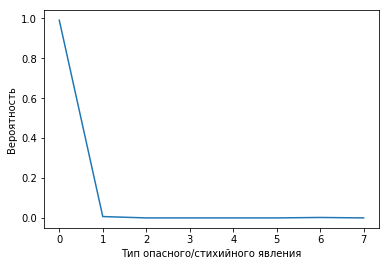

In [15]:
# step 10 show
import matplotlib.pyplot as plt
# predictions
plt.plot(np.squeeze(predictions))
plt.ylabel('Вероятность')
plt.xlabel('Тип опасного/стихийного явления')
# plt.title("Learning rate =" + str(learning_rate))
plt.show()

<BarContainer object of 8 artists>

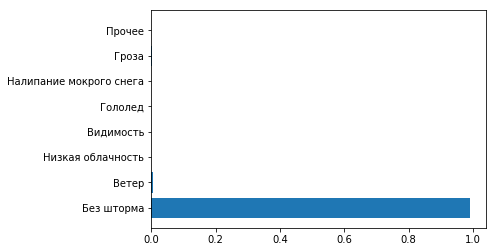

In [16]:
# step 11 show 2
import matplotlib.pyplot as plt

storm = ('Без шторма', 'Ветер', 'Низкая облачность', 'Видимость', 'Гололед', 'Налипание мокрого снега', 'Гроза', 'Прочее')
fig, ax = plt.subplots()
ax.barh(storm, np.squeeze(predictions))

# predictions.sum()